In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.gsam import *

In [3]:
ddf = gsam_feature_database()
# only look for PFs with heavy rain
df = ddf[ddf['heavy_rain_pixels']>0]
print(f'Fraction of features with HR: {df.shape[0]/ddf.shape[0]:0.2f}')

Fraction of features with HR: 0.66


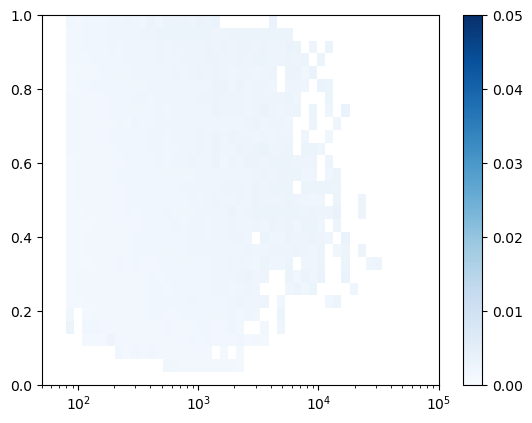

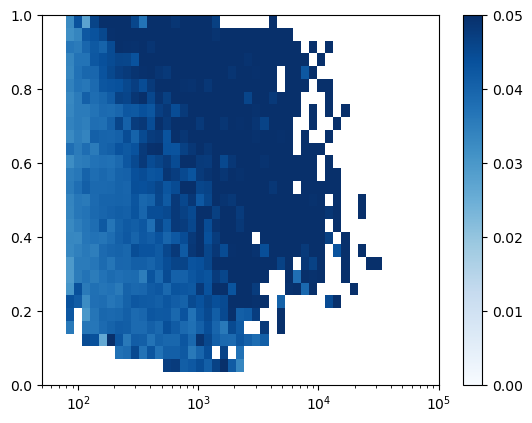

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_83570/806466366.py:7: RuntimeWarning: Mean of empty slice
  statistic=lambda x: np.nanmean(x) if x.size > 1 else np.nan,


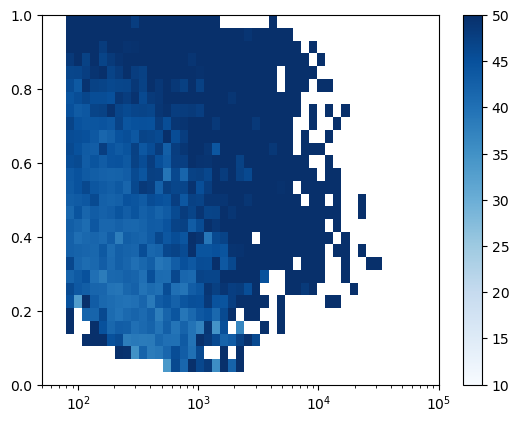

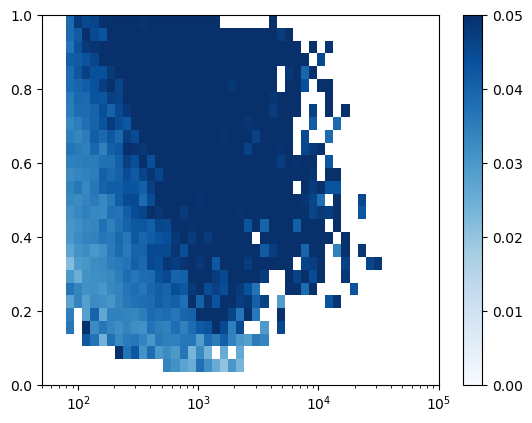

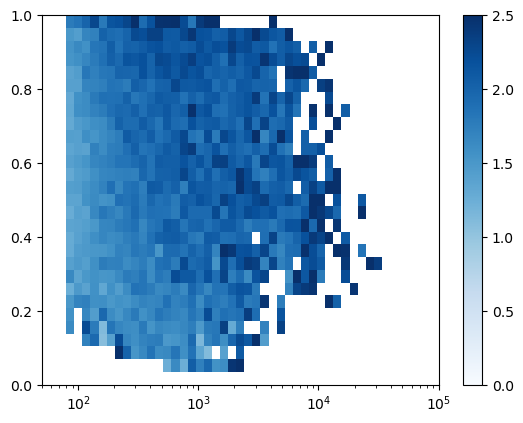

In [92]:
def _plot_bin_mean(ax, x_data, x_bins, y_data, y_bins, data, cmap, norm):
    mean = binned_statistic_2d(
        x=y_data,
        y=x_data,
        values=data,
        bins=[y_bins, x_bins],
        statistic=lambda x: np.nanmean(x) if x.size > 1 else np.nan,
    ).statistic

    x_mesh, y_mesh = np.meshgrid(x_bins, y_bins)

    c = ax.pcolormesh(
        x_mesh,
        y_mesh,
        mean,
        norm=norm,
        cmap=cmap,
    )
    cb = fig.colorbar(c)

    return ax

    
fig, ax = plt.subplots()
x_data = df['feature_size_pixels'] * 16
y_data = df['largest_heavy_rain_core_precip'] / df['total_precip']
x_bins = np.logspace(np.log10(50), 5, 50)
y_bins = np.linspace(0,1,30)
data = df['std_T2m']/df['mean_T2m']
cmap = plt.cm.Blues
norm = colors.Normalize(vmin=0, vmax=0.05)
_plot_bin_mean(ax, x_data, x_bins, y_data, y_bins, data, cmap, norm)
ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots()
x_data = df['feature_size_pixels'] * 16
y_data = df['largest_heavy_rain_core_precip'] / df['total_precip']
x_bins = np.logspace(np.log10(50), 5, 50)
y_bins = np.linspace(0,1,30)
data = df['std_Q2m']/df['mean_Q2m']
cmap = plt.cm.Blues
norm = colors.Normalize(vmin=0, vmax=0.05)
_plot_bin_mean(ax, x_data, x_bins, y_data, y_bins, data, cmap, norm)
ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots()
x_data = df['feature_size_pixels'] * 16
y_data = df['largest_heavy_rain_core_precip'] / df['total_precip']
x_bins = np.logspace(np.log10(50), 5, 50)
y_bins = np.linspace(0,1,30)
data = df['env_mean_PW']
cmap = plt.cm.Blues
norm = colors.Normalize(vmin=10, vmax=50)
_plot_bin_mean(ax, x_data, x_bins, y_data, y_bins, data, cmap, norm)
ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots()
x_data = df['feature_size_pixels'] * 16
y_data = df['largest_heavy_rain_core_precip'] / df['total_precip']
x_bins = np.logspace(np.log10(50), 5, 50)
y_bins = np.linspace(0,1,30)
data = df['std_PW']/df['mean_PW']
cmap = plt.cm.Blues
norm = colors.Normalize(vmin=0, vmax=0.05)
_plot_bin_mean(ax, x_data, x_bins, y_data, y_bins, data, cmap, norm)
ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots()
x_data = df['feature_size_pixels'] * 16
y_data = df['largest_heavy_rain_core_precip'] / df['total_precip']
x_bins = np.logspace(np.log10(50), 5, 50)
y_bins = np.linspace(0,1,30)
data = df['std_CIN']/df['mean_CIN']
cmap = plt.cm.Blues
norm = colors.Normalize(vmin=0, vmax=2.5)
_plot_bin_mean(ax, x_data, x_bins, y_data, y_bins, data, cmap, norm)
ax.set_xscale('log')
plt.show()


In [ ]:
df['']

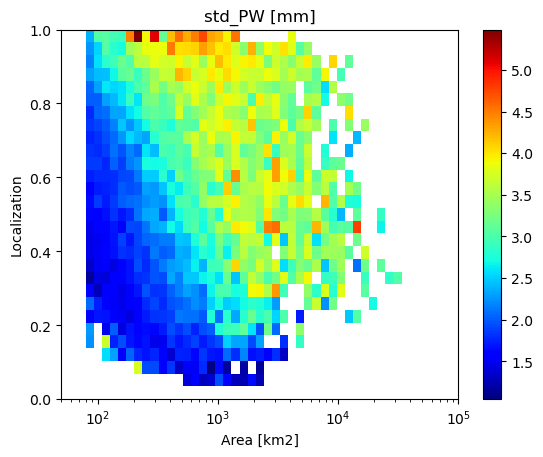

In [21]:
loc = df['largest_heavy_rain_core_precip']/df['total_precip']
area = df['feature_size_pixels'] * 16  # km2

area_bins = np.logspace(np.log10(50), 5, 50)
loc_bins = np.linspace(0, 1, 30)

value_to_plot = df['std_PW']
mean = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=value_to_plot,
    bins=[loc_bins, area_bins], 
    statistic=lambda x: np.nanmean(x) if x.size>1 else np.nan
).statistic

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

fig, ax = plt.subplots()
cmap = plt.cm.jet
norm = colors.Normalize(vmin=0, vmax=0.85)
c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean,
        # norm=norm,
        cmap=cmap, 
    )
ax.set_xscale('log')
ax.set_xlabel('Area [km2]')
ax.set_ylabel(r'Localization')
ax.set_title('std_PW [mm]')

cb = fig.colorbar(c)

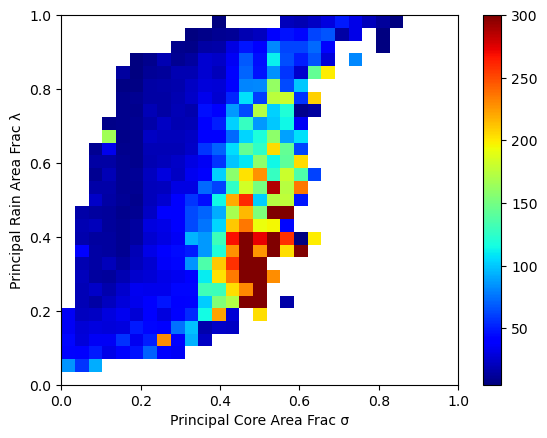

In [249]:
loc = df['largest_heavy_rain_core_precip'] / df['total_precip']
sigma = df['largest_heavy_rain_core_size_pixels'] / df['feature_size_pixels']

sigma_bins = np.linspace(0,1,30)
loc_bins = np.linspace(0,1,30)

value_to_plot = df['feature_size_pixels']

mean = binned_statistic_2d(
    x=loc,
    y=sigma,
    values=value_to_plot,
    bins=[loc_bins, sigma_bins],
    statistic=lambda x: np.nanmean(x) if x.size > 1 else np.nan
).statistic

x_mesh, y_mesh = np.meshgrid(sigma_bins, loc_bins)

fig, ax = plt.subplots()
cmap = plt.cm.jet

c = ax.pcolormesh(
    x_mesh,
    y_mesh,
    mean,
    norm=colors.Normalize(5, 300),
    cmap=cmap,
)

ax.set_xlabel('Principal Core Area Frac σ')
ax.set_ylabel('Principal Rain Area Frac λ')

fig.colorbar(c, ax=ax)

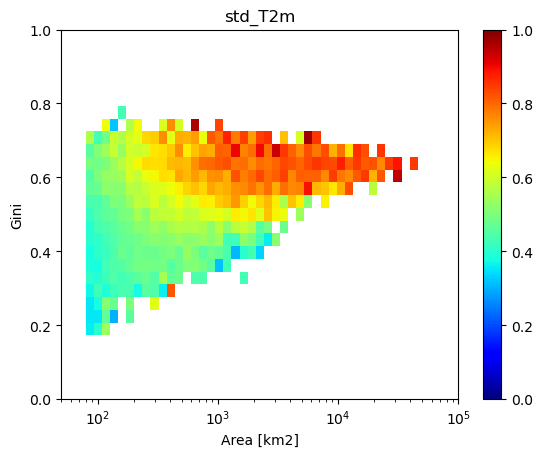

In [20]:
loc = df['largest_heavy_rain_core_precip']/df['total_precip']
loc = df['gini']
area = df['feature_size_pixels'] * 16  # km2

area_bins = np.logspace(np.log10(50), 5, 50)
loc_bins = np.linspace(0, 1, 30)

var_name = 'total_precip'
value_to_plot = df['std_T2m']
mean = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=value_to_plot,
    bins=[loc_bins, area_bins], 
    statistic=lambda x: np.nanmean(x) if x.size>1 else np.nan
).statistic

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

fig, ax = plt.subplots()
cmap = plt.cm.jet
norm = colors.Normalize(vmin=0, vmax=1)
c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean,
        norm=norm,
        cmap=cmap, 
    )
ax.set_xscale('log')
ax.set_xlabel('Area [km2]')
ax.set_ylabel(r'Gini')
ax.set_title('std_T2m')

cb = fig.colorbar(c)

In [101]:
file_list = region_core_files("MariCont")
loc = []
profiles = []
for fi, file in enumerate(file_list):
    clear_output()
    print(f'File {fi} of {len(file_list)}')
    ds = xr.open_dataset(file)

    # I only want data from systems of the same size
    target_size = 5000/16 # in pixels
    size_tolerance = 100/16

    size = ds['parent_system_num_pixels']
    ds = ds.where(abs(size-target_size)<size_tolerance).dropna(dim='core_number')

    if ds.core_number.size<=0:
        continue
    # Identify each unique parent system
    id_vars = ["parent_system_mean_PW", "parent_system_total_precip"]
    ds = ds.set_coords(id_vars)

    # Change to multindex for each unique parent system
    ds = ds.set_index({"core_number": id_vars})

    # Group over the multindex so each unique parent system is its own group
    gb = ds.groupby("core_number")



    for (parent_mean_pw, parent_mean_total_precip), sub in gb:
        # Get only the largest core from each parent system
        principal_core = sub.isel(core_number=sub['num_pixels'].argmax())

        loc.append(
            (principal_core['total_precip']/principal_core['parent_system_total_precip']).item()
        )

        Mc = principal_core['mean_massflux_profile']
        Mt = principal_core['parent_system_mean_massflux_profile']
        nc = principal_core['num_pixels']
        nr = principal_core['parent_system_num_pixels'] - nc
        mr = (nc*(Mt-Mc)) + (nr*Mt)
        Mr = mr/nr

        profiles.append(Mr)
            

File 231 of 232


In [99]:
case = np.arange(len(profiles))                     # 0, 1, 2, …
# stack the profile DataArrays along that new dimension
profiles_da = xr.concat(profiles, dim=xr.IndexVariable("case", case))

# LOC values → DataArray on the same dimension
loc_da = xr.DataArray(loc, coords={"case": case}, dims="case",
                      name="loc")

# -- assemble the final Dataset ------------------------------------------------
out_ds = xr.Dataset(
    data_vars={
        "mean_massflux_profile": profiles_da,   # dims: (case, level, …)
        "loc": loc_da                    # dims: (case,)
    }
)

Text(0.5, 1.0, 'ITCZ PFs 5000km2 pm 500km2 [Non Core Mean]')

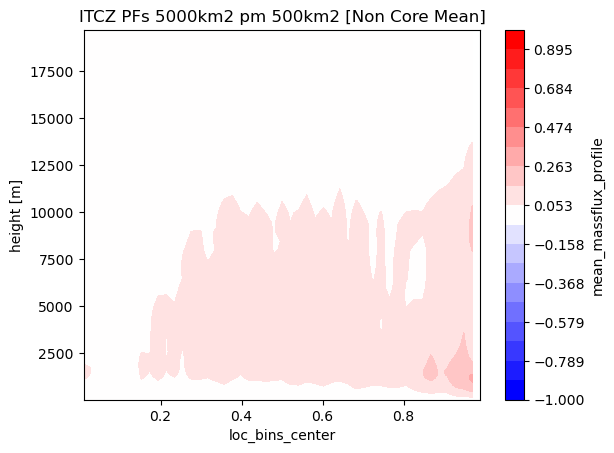

In [100]:
levels=np.linspace(-1, 1, 20)
cmap = plt.cm.bwr
norm = colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())
(
    out_ds.groupby_bins(out_ds['loc'], bins=np.linspace(0, 1, 50))
    .mean()
    .mean_massflux_profile
    .plot.contourf(
        y='z', 
        cmap=cmap,
        levels=levels,
        norm=norm
    )
)

plt.title('ITCZ PFs 5000km2 pm 500km2 [Non Core Mean]')

In [28]:
sub['num_pixels'].argmax()

<xarray.DataArray 'num_pixels' ()> Size: 8B
array(4)
Coordinates:
    time     float32 4B 32.0

In [72]:
ds['max_precip'].min()/24

<xarray.DataArray 'max_precip' ()> Size: 8B
array(2.16053359)
Coordinates:
    time     float32 4B 60.88

In [13]:
principal_core['total_precip']/principal_core['parent_system_total_precip']

<xarray.DataArray (core_number: 6)> Size: 48B
array([0.07142277, 0.07020396, 0.04899651, 0.07182904, 0.10205575,
       0.04062729])
Coordinates:
    time                        float32 4B 32.0
  * core_number                 (core_number) object 48B MultiIndex
    parent_system_mean_PW       (core_number) float64 48B 48.86 48.86 ... 48.86
  * parent_system_total_precip  (core_number) float64 48B 1.298e+03 ... 1.298...

In [94]:
for i, (key, data) in enumerate(gb):
    if i==100:
        print(data)
        break

<xarray.Dataset> Size: 2MB
Dimensions:                              (core_number: 1732, z: 61,
                                          parent_system: 1)
Coordinates:
  * core_number                          (core_number) int64 14kB 0 1 ... 1731
  * z                                    (z) float32 244B 20.0 61.2 ... 1.97e+04
    time                                 float32 4B ...
  * parent_system                        (parent_system) object 8B MultiIndex
  * parent_system_mean_PW                (parent_system) float64 8B 35.69
  * parent_system_total_precip           (parent_system) float64 8B 144.3
  * parent_system_num_pixels             (parent_system) int64 8B 7
Data variables:
    core_id_string                       (core_number) <U27 187kB ...
    mean_qv_profile                      (core_number, z) float32 423kB ...
    mean_massflux_profile                (core_number, z) float32 423kB ...
    parent_system_mean_qv_profile        (core_number, z) float32 423kB ...
    pare

In [77]:
data['mean_qv_profile'].data.shape

(1732, 61)

In [75]:
gb

<DatasetGroupBy, grouped over 1 grouper(s), 646 groups in total:
    'parent_system': 646 groups with labels (56.96832275390625,, 86.8221...>

In [34]:
import pickle
with open('../data/gsam_cores/MariCont_thresholds.pkl', 'rb') as f:
    obj = pickle.load(f)

print(obj['region_p90']/24 )

5.036411603291829


In [36]:
ds['core_id_string'].data

array(['20200201_000000_corenum001', '20200201_000000_corenum002',
       '20200201_000000_corenum003', ..., '20200201_000000_corenum1730',
       '20200201_000000_corenum1731', '20200201_000000_corenum1732'],
      dtype='<U27')